# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), # tensor로 펴준다.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

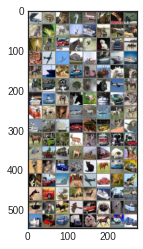

truck	 frog	 cat	 bird	


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [20]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1), # [batch_size, 3, 32, 32] -> [batch_size, 32, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1), # [batch_size, 32, 32, 32] -> [batch_size, 32, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # [batch_size, 32, 32, 32] -> [batch_size, 32, 16, 16]
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1), # [batch_size, 32, 16, 16] -> [batch_size, 64, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # [batch_size, 64, 16, 16] -> [batch_size, 64, 8, 8]

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1), # [batch_size, 64, 8, 8] -> [batch_size, 128, 8, 8]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # [batch_size, 128, 8, 8] -> [batch_size, 128, 4, 4]

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1), # [batch_size, 64, 8, 8] -> [batch_size, 128, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)


        
      )

      self.flat = nn.Flatten()

      self.fclayer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10)        
      )
    
    def forward(self, x):
      x = self.conv(x)
      x = self.flat(x)
      x = self.fclayer(x)
      return x

In [21]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, ke

In [22]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([128, 3, 32, 32])

In [23]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([128, 10])

In [24]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           1,792
       BatchNorm2d-2           [64, 64, 32, 32]             128
              ReLU-3           [64, 64, 32, 32]               0
            Conv2d-4           [64, 64, 32, 32]          36,928
       BatchNorm2d-5           [64, 64, 32, 32]             128
              ReLU-6           [64, 64, 32, 32]               0
         MaxPool2d-7           [64, 64, 16, 16]               0
            Conv2d-8          [64, 128, 16, 16]          73,856
       BatchNorm2d-9          [64, 128, 16, 16]             256
             ReLU-10          [64, 128, 16, 16]               0
           Conv2d-11          [64, 128, 16, 16]         147,584
      BatchNorm2d-12          [64, 128, 16, 16]             256
             ReLU-13          [64, 128, 16, 16]               0
        MaxPool2d-14            [64, 12

## 손실함수와 옵티마이저

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(myNet.parameters(), lr=0.01)
#optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=14, gamma=0.1)

## 모델 학습

In [26]:
# epochs = 10

for epoch in range(20):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                 # 가중치 초기화

        outputs = myNet(inputs)                      # y_pred
        loss = criterion(outputs, labels)                  # 손실함수를 이용해서 loss계산
        loss.backward()                            # back-propagation
        optimizer.step()                           # 가중치 업데이트

        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
    lr_scheduler.step() 

Epoch: 1, Batch: 100, Loss: 0.12559509873390198
Epoch: 1, Batch: 200, Loss: 0.1056861388683319
Epoch: 1, Batch: 300, Loss: 0.09904733002185821
Epoch: 2, Batch: 100, Loss: 0.09305711001157761
Epoch: 2, Batch: 200, Loss: 0.0849094681739807
Epoch: 2, Batch: 300, Loss: 0.07691194987297058
Epoch: 3, Batch: 100, Loss: 0.06477282702922821
Epoch: 3, Batch: 200, Loss: 0.06021420410275459
Epoch: 3, Batch: 300, Loss: 0.0558907790184021
Epoch: 4, Batch: 100, Loss: 0.0481707544028759
Epoch: 4, Batch: 200, Loss: 0.045822644233703615
Epoch: 4, Batch: 300, Loss: 0.04319963052868843
Epoch: 5, Batch: 100, Loss: 0.03817068174481392
Epoch: 5, Batch: 200, Loss: 0.036853819012641904
Epoch: 5, Batch: 300, Loss: 0.03672114396095276
Epoch: 6, Batch: 100, Loss: 0.031764764428138734
Epoch: 6, Batch: 200, Loss: 0.03193174985051155
Epoch: 6, Batch: 300, Loss: 0.03183070942759514
Epoch: 7, Batch: 100, Loss: 0.027289674162864683
Epoch: 7, Batch: 200, Loss: 0.027559392333030702
Epoch: 7, Batch: 300, Loss: 0.028142574

## 모델의 저장 및 로드

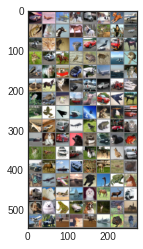

	car 	plane 	plane 	dog


In [27]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [28]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [29]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [30]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                   # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                 # y_pred                                                                       
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

88.29


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [31]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 87.17948717948718%
Accuracy of car: 92.3076923076923%
Accuracy of bird: 80.55555555555556%
Accuracy of cat: 68.96551724137932%
Accuracy of deer: 81.25%
Accuracy of dog: 82.6086956521739%
Accuracy of frog: 82.3529411764706%
Accuracy of horse: 93.54838709677419%
Accuracy of ship: 96.42857142857143%
Accuracy of truck: 84.0%
